In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('ADANIPORTS.NS', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,123.750000,111.000000,122.800003,114.699997,1572363.0,108.697311
2012-01-03,120.900002,115.000000,117.500000,120.300003,1385662.0,114.004265
2012-01-04,123.500000,118.000000,121.000000,122.849998,1259249.0,116.420792
2012-01-05,127.599998,121.300003,122.000000,126.699997,788405.0,120.069298
2012-01-06,128.750000,124.300003,126.250000,127.699997,1036623.0,121.016975
...,...,...,...,...,...,...
2022-02-28,709.650024,684.500000,690.000000,707.500000,4288186.0,707.500000
2022-03-02,717.900024,697.599976,702.950012,710.299988,4448558.0,710.299988
2022-03-03,724.599976,703.000000,718.799988,706.700012,7533817.0,706.700012


In [73]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.79)
training_data_len

1983

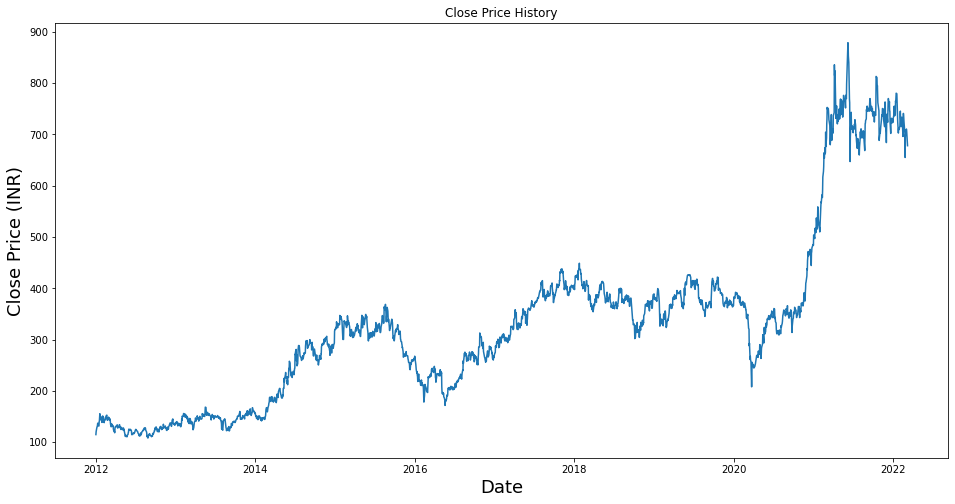

In [74]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (INR)',fontsize=18)
plt.show()

In [75]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00869452],
       [0.01596159],
       [0.0192707 ],
       ...,
       [0.77692711],
       [0.76842726],
       [0.73942383]])

In [76]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00869452, 0.01596159, 0.0192707 , 0.0242668 , 0.02556449,
       0.0314041 , 0.03691928, 0.0376979 , 0.03198805, 0.03056061,
       0.03056061, 0.04152608, 0.04373215, 0.05372436, 0.06151051,
       0.05028549, 0.05456787, 0.04567869, 0.05073969, 0.03944977,
       0.04963665, 0.04658707, 0.05580068, 0.05482741, 0.05203738,
       0.04042304, 0.0419154 , 0.03886582, 0.04528938, 0.04548404,
       0.04691149, 0.05080456, 0.05138854, 0.05515183, 0.05794186,
       0.0465222 , 0.04678173, 0.04502984, 0.04626265, 0.05203738,
       0.0527511 , 0.05041527, 0.05106412, 0.04567869, 0.04613289,
       0.04833896, 0.03503763, 0.02841941, 0.02997665, 0.0360109 ,
       0.03120945, 0.0326369 , 0.03094992, 0.03159876, 0.03004152,
       0.02322866, 0.02004931, 0.01628602, 0.01751882, 0.01330132])]
[0.021022576513740815]



In [77]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [78]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(1923, 60, 1)

In [79]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [80]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [81]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1923/1923 [==============================] - 33s 16ms/step - loss: 5.6580e-04


In [82]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [83]:
x_test = np.array(x_test)

In [84]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [85]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [86]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

12.184475162636645

C:\Users\kapoo\AppData\Local\Temp/ipykernel_2816/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


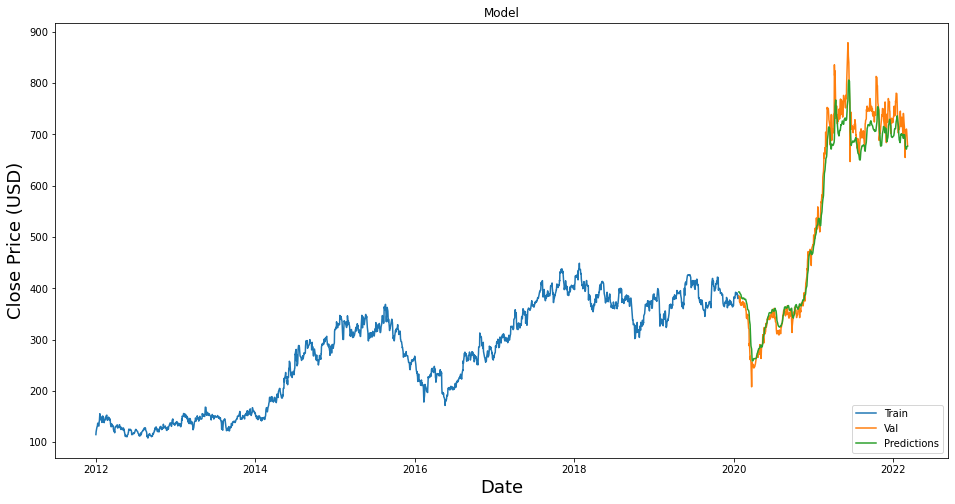

In [87]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [88]:
valid

,Close,Predictions
Date,,
2020-01-24,384.750000,392.794373
2020-01-27,381.250000,392.644836
2020-01-28,372.950012,392.144897
2020-01-29,383.350006,390.307526
2020-01-30,378.000000,389.819672
...,...,...
2022-02-28,707.500000,671.689575
2022-03-02,710.299988,671.111206
2022-03-03,706.700012,673.330139


In [89]:
adaniport_quote = web.DataReader('ADANIPORTS.NS', data_source='yahoo',start='2012-01-01', end='2022-03-08')
new_df = adaniport_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[673.77386]]


In [90]:
adaniport_quote2 = web.DataReader('ADANIPORTS.NS', data_source='yahoo',start='2022-03-01', end='2022-03-08')
print(adaniport_quote2['Close'])

Date
2022-03-02    710.299988
2022-03-03    706.700012
2022-03-04    700.150024
2022-03-07    677.799988
Name: Close, dtype: float64
